# Pull for gasoline

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# API endpoint from the image
url = "https://api.eia.gov/v2/petroleum/move/pipe/data/"
params_gasoline = {
    "api_key": "5rUUB3L0yR6oeGDJPSonz9skOnmmZPzh34VM5iGh",
    "frequency": "monthly",
    "data[0]": "value",
    "facets[series][]": [
            "MBCMPP1P31",
            "MGFMPP1P31"
        ],
    "start": "2018-01",
    "end": "2025-05",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}
params_gasoil = {
    "api_key": "5rUUB3L0yR6oeGDJPSonz9skOnmmZPzh34VM5iGh",
    "frequency": "monthly",
    "data[0]": "value",
    "facets[series][]": "MDIMPP1P31",
    "start": "2018-01",
    "end": "2025-05",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}
# Make GET request
def get_data(url, params):
    response = requests.get(url, params)
    data = response.json()
    # Convert to DataFrame
    df = pd.DataFrame(data['response']['data'])

    # Show first rows
    return df

df_gasoine = get_data(url, params_gasoline)
df_gasoil = get_data(url, params_gasoil)
display(df_gasoine.head())
display(df_gasoil.head())

,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2025-04,R10-R30,PADD 3,EPM0F,Finished Motor Gasoline,LMV,Movements by Pipeline,MGFMPP1P31,East Coast (PADD 1) Receipts by Pipeline from ...,723,MBBL
1,2025-04,R10-R30,PADD 3,EPOBG,Gasoline Blending Components,LMV,Movements by Pipeline,MBCMPP1P31,East Coast (PADD 1) Receipts by Pipeline from ...,43960,MBBL
2,2025-03,R10-R30,PADD 3,EPOBG,Gasoline Blending Components,LMV,Movements by Pipeline,MBCMPP1P31,East Coast (PADD 1) Receipts by Pipeline from ...,45590,MBBL
3,2025-03,R10-R30,PADD 3,EPM0F,Finished Motor Gasoline,LMV,Movements by Pipeline,MGFMPP1P31,East Coast (PADD 1) Receipts by Pipeline from ...,1160,MBBL
4,2025-02,R10-R30,PADD 3,EPOBG,Gasoline Blending Components,LMV,Movements by Pipeline,MBCMPP1P31,East Coast (PADD 1) Receipts by Pipeline from ...,45686,MBBL


,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2025-04,R10-R30,PADD 3,EPD0,Distillate Fuel Oil,LMV,Movements by Pipeline,MDIMPP1P31,East Coast (PADD 1) Receipts by Pipeline from ...,20522,MBBL
1,2025-03,R10-R30,PADD 3,EPD0,Distillate Fuel Oil,LMV,Movements by Pipeline,MDIMPP1P31,East Coast (PADD 1) Receipts by Pipeline from ...,23737,MBBL
2,2025-02,R10-R30,PADD 3,EPD0,Distillate Fuel Oil,LMV,Movements by Pipeline,MDIMPP1P31,East Coast (PADD 1) Receipts by Pipeline from ...,24658,MBBL
3,2025-01,R10-R30,PADD 3,EPD0,Distillate Fuel Oil,LMV,Movements by Pipeline,MDIMPP1P31,East Coast (PADD 1) Receipts by Pipeline from ...,23875,MBBL
4,2024-12,R10-R30,PADD 3,EPD0,Distillate Fuel Oil,LMV,Movements by Pipeline,MDIMPP1P31,East Coast (PADD 1) Receipts by Pipeline from ...,24471,MBBL


#  Clean dataframe

In [3]:
def clean(df, group=False):
    out = df[['period','value']].copy()
    out['value'] = pd.to_numeric(out['value'], errors='coerce') / 30
    out['units'] = 'KBD'
    if group:
        out = out.groupby('period', as_index=False)['value'].sum()    
    return out.sort_values('period').reset_index(drop=True)

# Gasoline: group + sum by period
gasoline_kbd = clean(df_gasoine, group=True)
# Gasoil: no grouping
gasoil_kbd   = clean(df_gasoil, group=False)


In [4]:
gasoline_kbd.to_csv(r'C:\Users\siwz@equinor.com\OneDrive - Equinor\personal\projects\Colonial Pipeline Forecast/gasoline_pipeline_EIA.csv', index = False)
gasoil_kbd.to_csv(r'C:\Users\siwz@equinor.com\OneDrive - Equinor\personal\projects\Colonial Pipeline Forecast/gasoil_pipline_EIA.csv', index = False)

# Test Correlation

In [5]:
gasoline_kbd['value'].corr(gasoil_kbd['value'])

0.16113965822223125

# Examine data

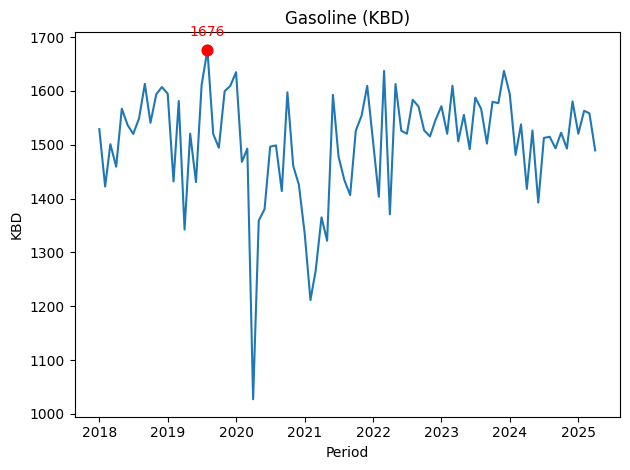

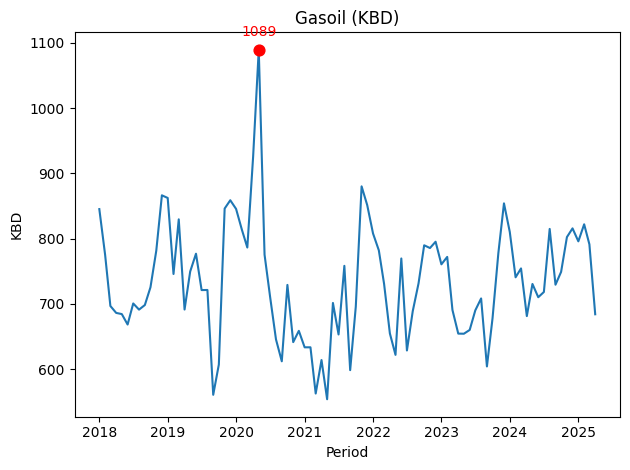

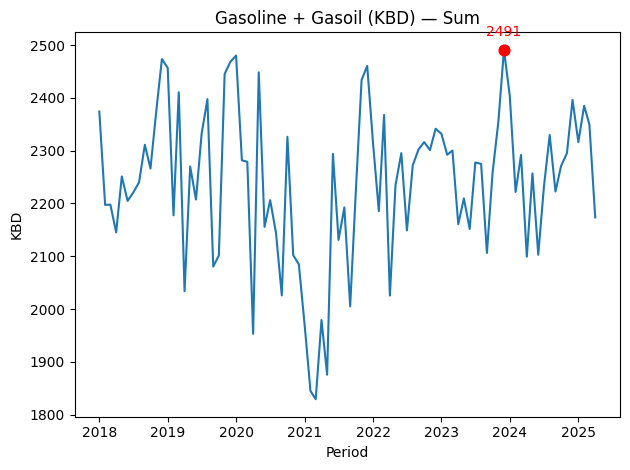

In [6]:
g = gasoline_kbd[['period','value']].copy()
d = gasoil_kbd[['period','value']].copy()

for df in (g, d):
    df['period'] = pd.to_datetime(df['period'], errors='coerce')
    df.sort_values('period', inplace=True)

# Sum series
combo = (
    g.rename(columns={'value':'gasoline'})
     .merge(d.rename(columns={'value':'gasoil'}), on='period', how='inner')
     .reset_index(drop=True)
)
combo['sum_kbd'] = combo['gasoline'] + combo['gasoil']

# Max points
i_max_g = g['value'].idxmax()
xg = g.loc[i_max_g, 'period']
yg = g.loc[i_max_g, 'value']

i_max_d = d['value'].idxmax()
xd = d.loc[i_max_d, 'period']
yd = d.loc[i_max_d, 'value']

i_max_sum = combo['sum_kbd'].idxmax()
xs = combo.loc[i_max_sum, 'period']
ys = combo.loc[i_max_sum, 'sum_kbd']

# Plot 1: Gasoline
plt.figure()
plt.plot(g['period'], g['value'])
plt.scatter([xg], [yg], s=60, color='red', zorder=3)
plt.annotate(f"{yg:.0f}", xy=(xg, yg), xytext=(0, 10),
             textcoords='offset points', ha='center', color='red')
plt.title('Gasoline (KBD)')
plt.xlabel('Period')
plt.ylabel('KBD')
plt.tight_layout()
plt.show()

# Plot 2: Gasoil
plt.figure()
plt.plot(d['period'], d['value'])
plt.scatter([xd], [yd], s=60, color='red', zorder=3)
plt.annotate(f"{yd:.0f}", xy=(xd, yd), xytext=(0, 10),
             textcoords='offset points', ha='center', color='red')
plt.title('Gasoil (KBD)')
plt.xlabel('Period')
plt.ylabel('KBD')
plt.tight_layout()
plt.show()

# Plot 3: Sum with max highlighted in red and labeled
plt.figure()
plt.plot(combo['period'], combo['sum_kbd'])
plt.scatter([xs], [ys], s=60, color='red', zorder=3)
plt.annotate(f"{ys:.0f}", xy=(xs, ys), xytext=(0, 10),
             textcoords='offset points', ha='center', color='red')
plt.title('Gasoline + Gasoil (KBD) — Sum')
plt.xlabel('Period')
plt.ylabel('KBD')
plt.tight_layout()
plt.show()
